In [7]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import testCases #参见资料包，或者在文章底部copy
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward #参见资料包
import lr_utils #参见资料包，或者在文章底部copy

In [8]:
np.random.seed(1)
def initialize_parameters(n_x, n_h, n_y):
    W1=np.random.randn(n_h, n_x) * 0.01
    b1=np.zeros((n_h, 1))
    W2=np.random.randn(n_y, n_h)*0.01
    b2=np.zeros((n_y, 1))
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    
    parameters={"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    return parameters
# print("==============测试initialize_parameters==============")
# parameters = initialize_parameters(3,2,1)
# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))

In [9]:
def initialize_parameters_deep(layers_dims):
    """
    此函数是为了初始化多层网络参数而使用的函数。
    参数：
        layers_dims - 包含我们网络中每个图层的节点数量的列表
    
    返回：
        parameters - 包含参数“W1”，“b1”，...，“WL”，“bL”的字典：
                     W1 - 权重矩阵，维度为（layers_dims [1]，layers_dims [1-1]）
                     bl - 偏向量，维度为（layers_dims [1]，1）
    """
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims)
    
    for l in range(1,L): 
        #从1开始，W1是[n1,n0]
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) / np.sqrt(layers_dims[l - 1])
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
        
        #确保我要的数据的格式是正确的
        assert(parameters["W" + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
        assert(parameters["b" + str(l)].shape == (layers_dims[l], 1))
        
    return parameters
#测试initialize_parameters_deep
# print("==============测试initialize_parameters_deep==============")
# layers_dims = [5,4,3]
# parameters = initialize_parameters_deep(layers_dims)
# print("W1 = " + str(parameters["W1"]))
# print("b1 = " + str(parameters["b1"]))
# print("W2 = " + str(parameters["W2"]))
# print("b2 = " + str(parameters["b2"]))

In [10]:
def linear_forward(A,W,b):
    """
    实现前向传播的线性部分。

    参数：
        A - 来自上一层（或输入数据）的激活，维度为(上一层的节点数量，示例的数量）
        W - 权重矩阵，numpy数组，维度为（当前图层的节点数量，前一图层的节点数量）
        b - 偏向量，numpy向量，维度为（当前图层节点数量，1）

    返回：
         Z - 激活功能的输入，也称为预激活参数
         cache - 一个包含“A”，“W”和“b”的字典，存储这些变量以有效地计算后向传递
    """
    Z = np.dot(W,A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A,W,b)
    return Z,cache
#测试linear_forward
# print("==============测试linear_forward==============")
# A,W,b = testCases.linear_forward_test_case()
# Z,linear_cache = linear_forward(A,W,b)
# print("Z = " + str(Z))

In [11]:
def linear_activation_forward(A_prev,W,b,activation):
    """
    实现LINEAR-> ACTIVATION 这一层的前向传播

    参数：
        A_prev - 来自上一层（或输入层）的激活，维度为(上一层的节点数量，示例数）
        W - 权重矩阵，numpy数组，维度为（当前层的节点数量，前一层的大小）
        b - 偏向量，numpy阵列，维度为（当前层的节点数量，1）
        activation - 选择在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】

    返回：
        A - 激活函数的输出，也称为激活后的值
        cache - 一个包含“linear_cache”和“activation_cache”的字典，我们需要存储它以有效地计算后向传递
    """

    if activation == "sigmoid":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    assert(A.shape == (W.shape[0],A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A,cache
#测试linear_activation_forward
# print("==============测试linear_activation_forward==============")
# A_prev, W,b = testCases.linear_activation_forward_test_case()

# A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "sigmoid")
# print("sigmoid，A = " + str(A))

# A, linear_activation_cache = linear_activation_forward(A_prev, W, b, activation = "relu")
# print("ReLU，A = " + str(A))

In [12]:
def L_model_forward(X,parameters):
    """
    实现[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID计算前向传播，也就是多层网络的前向传播，为后面每一层都执行LINEAR和ACTIVATION
    
    参数：
        X - 数据，numpy数组，维度为（输入节点数量，示例数）
        parameters - initialize_parameters_deep（）的输出
    
    返回：
        AL - 最后的激活值
        caches - 包含以下内容的缓存列表：
                 linear_relu_forward（）的每个cache（有L-1个，索引为从0到L-2）
                 linear_sigmoid_forward（）的cache（只有一个，索引为L-1）
    """
    caches = []
    A = X
    L = len(parameters)//2 #地板除，保留整数
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "relu")
        caches.append(cache)
    
    AL, cache= linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], "sigmoid") #输出层,AL是输出层的激活值
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    return AL,caches
#测试L_model_forward
# print("==============测试L_model_forward==============")
# X,parameters = testCases.L_model_forward_test_case()
# AL,caches = L_model_forward(X,parameters)
# print("AL = " + str(AL))
# print("caches 的长度为 = " + str(len(caches)))

In [40]:
def compute_cost(AL,Y):
    """
    实施等式（4）定义的成本函数。

    参数：
        AL - 与标签预测相对应的概率向量，维度为（1，示例数量）
        Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）

    返回：
        cost - 交叉熵成本
    """
    m = Y.shape[1]
    cost=-1/m * np.sum(np.multiply(Y,np.log(AL)) + np.multiply(1-Y,1-np.log(AL)))
    cost=np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost
#测试compute_cost
# print("==============测试compute_cost==============")
# Y,AL = testCases.compute_cost_test_case()
# print("cost = " + str(compute_cost(AL, Y)))

==============测试compute_cost==============
cost = 0.41493159961539694


In [14]:
def linear_backward(dZ,cache):
    """
    为单层实现反向传播的线性部分（第L层）

    参数：
         dZ - 相对于（当前第l层的）线性输出的成本梯度---------------------由给的relu/sigmoid_backward算出！！！！！
         cache - 来自当前层前向传播的值的元组（A_prev，W，b）

    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度，与W的维度相同
         db - 相对于b（当前层l）的成本梯度，与b维度相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/ m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
    
    assert(dA_prev.shape == A_prev.shape)
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    
    return dA_prev, dW, db

#测试linear_backward
# print("==============测试linear_backward==============")
# dZ, linear_cache = testCases.linear_backward_test_case()

# dA_prev, dW, db = linear_backward(dZ, linear_cache)
# print ("dA_prev = "+ str(dA_prev))
# print ("dW = " + str(dW))
# print ("db = " + str(db))

In [15]:
def linear_activation_backward(dA,cache,activation="relu"):
    """
    实现LINEAR-> ACTIVATION层的后向传播。
    
    参数：
         dA - 当前层l的激活后的梯度值
         cache - 我们存储的用于有效计算反向传播的值的元组（值为linear_cache，activation_cache）
         activation - 要在此层中使用的激活函数名，字符串类型，【"sigmoid" | "relu"】
    返回：
         dA_prev - 相对于激活（前一层l-1）的成本梯度值，与A_prev维度相同
         dW - 相对于W（当前层l）的成本梯度值，与W的维度相同
         db - 相对于b（当前层l）的成本梯度值，与b的维度相同
    """
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev,dW,db

#测试linear_activation_backward
# print("==============测试linear_activation_backward==============")
# AL, linear_activation_cache = testCases.linear_activation_backward_test_case()
 
# dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "sigmoid")
# print ("sigmoid:")
# print ("dA_prev = "+ str(dA_prev))
# print ("dW = " + str(dW))
# print ("db = " + str(db) + "\n")
 
# dA_prev, dW, db = linear_activation_backward(AL, linear_activation_cache, activation = "relu")
# print ("relu:")
# print ("dA_prev = "+ str(dA_prev))
# print ("dW = " + str(dW))
# print ("db = " + str(db))

In [16]:
def L_model_backward(AL,Y,caches):
    """
    对[LINEAR-> RELU] *（L-1） - > LINEAR - > SIGMOID组执行反向传播，就是多层网络的向后传播
    
    参数：
     AL - 概率向量，正向传播的输出（L_model_forward（））
     Y - 标签向量（例如：如果不是猫，则为0，如果是猫则为1），维度为（1，数量）
     caches - 包含以下内容的cache列表：
                 linear_activation_forward（"relu"）的cache，不包含输出层
                 linear_activation_forward（"sigmoid"）的cache
    
    返回：
     grads - 具有梯度值的字典
              grads [“dA”+ str（l）] = ...
              grads [“dW”+ str（l）] = ...
              grads [“db”+ str（l）] = ...
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")#dA2->dA1, dW2, db2
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads
# #测试L_model_backward
# print("==============测试L_model_backward==============")
# AL, Y_assess, caches = testCases.L_model_backward_test_case()
# grads = L_model_backward(AL, Y_assess, caches)
# print ("dW1 = "+ str(grads["dW1"]))
# print ("db1 = "+ str(grads["db1"]))
# print ("dA1 = "+ str(grads["dA1"]))

In [18]:
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数
    
    参数：
     parameters - 包含你的参数的字典
     grads - 包含梯度值的字典，是L_model_backward的输出
    
    返回：
     parameters - 包含更新参数的字典
                   参数[“W”+ str（l）] = ...
                   参数[“b”+ str（l）] = ...
    """
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    
    return parameters
#测试update_parameters
# print("==============测试update_parameters==============")
# parameters, grads = testCases.update_parameters_test_case()
# parameters = update_parameters(parameters, grads, 0.1)
 
# print ("W1 = "+ str(parameters["W1"]))
# print ("b1 = "+ str(parameters["b1"]))
# print ("W2 = "+ str(parameters["W2"]))
# print ("b2 = "+ str(parameters["b2"]))

==============测试update_parameters==============
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]


第 0 次迭代，成本值为: -0.8711773700305774
第 100 次迭代，成本值为: -0.9757317358961097
第 200 次迭代，成本值为: -0.9983662989313674
第 300 次迭代，成本值为: -1.0532839788058146
第 400 次迭代，成本值为: -1.1600907471990058
第 500 次迭代，成本值为: -1.2949036870621657
第 600 次迭代，成本值为: -1.49038777673109
第 700 次迭代，成本值为: -1.6840917283462637
第 800 次迭代，成本值为: -1.9680477931361182
第 900 次迭代，成本值为: -2.197364474628066
第 1000 次迭代，成本值为: -2.481443506330307
第 1100 次迭代，成本值为: -2.712242067222288
第 1200 次迭代，成本值为: -2.932881234244403
第 1300 次迭代，成本值为: -3.1513365281207295
第 1400 次迭代，成本值为: -3.233204247812043
第 1500 次迭代，成本值为: -3.422806283865162
第 1600 次迭代，成本值为: -3.7241965225875475
第 1700 次迭代，成本值为: -3.494979406726969
第 1800 次迭代，成本值为: -3.560265468114918
第 1900 次迭代，成本值为: -3.6109571977633177
第 2000 次迭代，成本值为: -3.7431274886367953
第 2100 次迭代，成本值为: -3.8398590656615688
第 2200 次迭代，成本值为: -3.898646360316177
第 2300 次迭代，成本值为: -3.9789365720736414
第 2400 次迭代，成本值为: -4.101442017616956


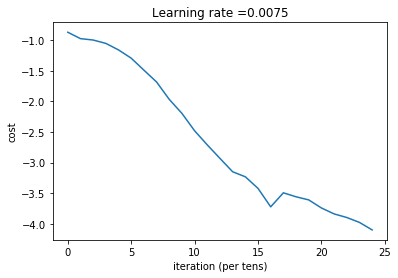

In [27]:
def two_layer_model(X,Y,layers_dims,learning_rate=0.0075,num_iterations=3000,print_cost=False,isPlot=True):
    """
    实现一个两层的神经网络，【LINEAR->RELU】 -> 【LINEAR->SIGMOID】
    参数：
        X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_x,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    返回:
        parameters - 一个包含W1，b1，W2，b2的字典变量
    """
    np.random.seed(1)
    grads = {}
    costs = []
    (n_x,n_h,n_y) = layers_dims
    #初始化参数
    parameters = initialize_parameters(n_x,n_h,n_y)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    #开始迭代
    for i in range(num_iterations):
        
        #前向传播 + parameters
        A1, cache1 = linear_activation_forward(X,W1,b1, "relu")
        A2, cache2 = linear_activation_forward(A1,W2,b2, "sigmoid")
        #计算成本
        cost = compute_cost(A2,Y)
        
        #向后传播 + grads
        dA2 = -(np.divide(Y,A2)-np.divide(1-Y,1-A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        #保存到grads中
        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        #更新参数
        parameters = update_parameters(parameters, grads, learning_rate)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        
        #print成本值
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("第", i , "次迭代，成本值为:", np.squeeze(cost))
        
        #绘制图片
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel("cost")
        plt.xlabel("iteration (per tens)")
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
    return parameters


train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y

n_x = 12288
n_h = 7
n_y = 1
layers_dims = (n_x,n_h,n_y)

parameters = two_layer_model(train_x, train_set_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True,isPlot=True)

In [52]:
def predict(X, y, parameters):
    """
    该函数用于预测L层神经网络的结果，当然也包含两层
    
    参数：
     X - 测试集
     y - 标签
     parameters - 训练模型的参数
    
    返回：
     p - 给定数据集X的预测
    """
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    probas, caches = L_model_forward(X, parameters)
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("准确度为:" + str(float(np.sum((p == y)) / m)))
    return p
predictions_train = predict(train_x, train_y, parameters) #训练集
predictions_test = predict(test_x, test_y, parameters) #测试集

准确度为:0.9952153110047847
准确度为:0.74


第 0 次迭代，成本值为： -0.8516457682924006
第 100 次迭代，成本值为： -0.8927526884298292
第 200 次迭代，成本值为： -0.9132867579126155
第 300 次迭代，成本值为： -0.9338098958927282
第 400 次迭代，成本值为： -0.9598569266222631
第 500 次迭代，成本值为： -0.9939899142708837
第 600 次迭代，成本值为： -1.0415622607620258
第 700 次迭代，成本值为： -1.102351596919266
第 800 次迭代，成本值为： -1.1833994282362352
第 900 次迭代，成本值为： -1.2604363507926588
第 1000 次迭代，成本值为： -1.3538966858778854
第 1100 次迭代，成本值为： -1.4121427586487132
第 1200 次迭代，成本值为： -1.5075283039518732
第 1300 次迭代，成本值为： -1.5790996843255125
第 1400 次迭代，成本值为： -1.6499829639406016
第 1500 次迭代，成本值为： -1.7162962730445859
第 1600 次迭代，成本值为： -1.7823880918009367
第 1700 次迭代，成本值为： -1.8451028116606083
第 1800 次迭代，成本值为： -1.938565154103335
第 1900 次迭代，成本值为： -2.1095643347477444
第 2000 次迭代，成本值为： -1.4809667271082085
第 2100 次迭代，成本值为： -2.401305419331581
第 2200 次迭代，成本值为： -2.8152579113740304
第 2300 次迭代，成本值为： -3.0885201101067166
第 2400 次迭代，成本值为： -3.272274727100172
第 2500 次迭代，成本值为： -3.399292816209888
第 2600 次迭代，成本值为： -3.5152044772013142
第 2700 次迭代，成本值为： -

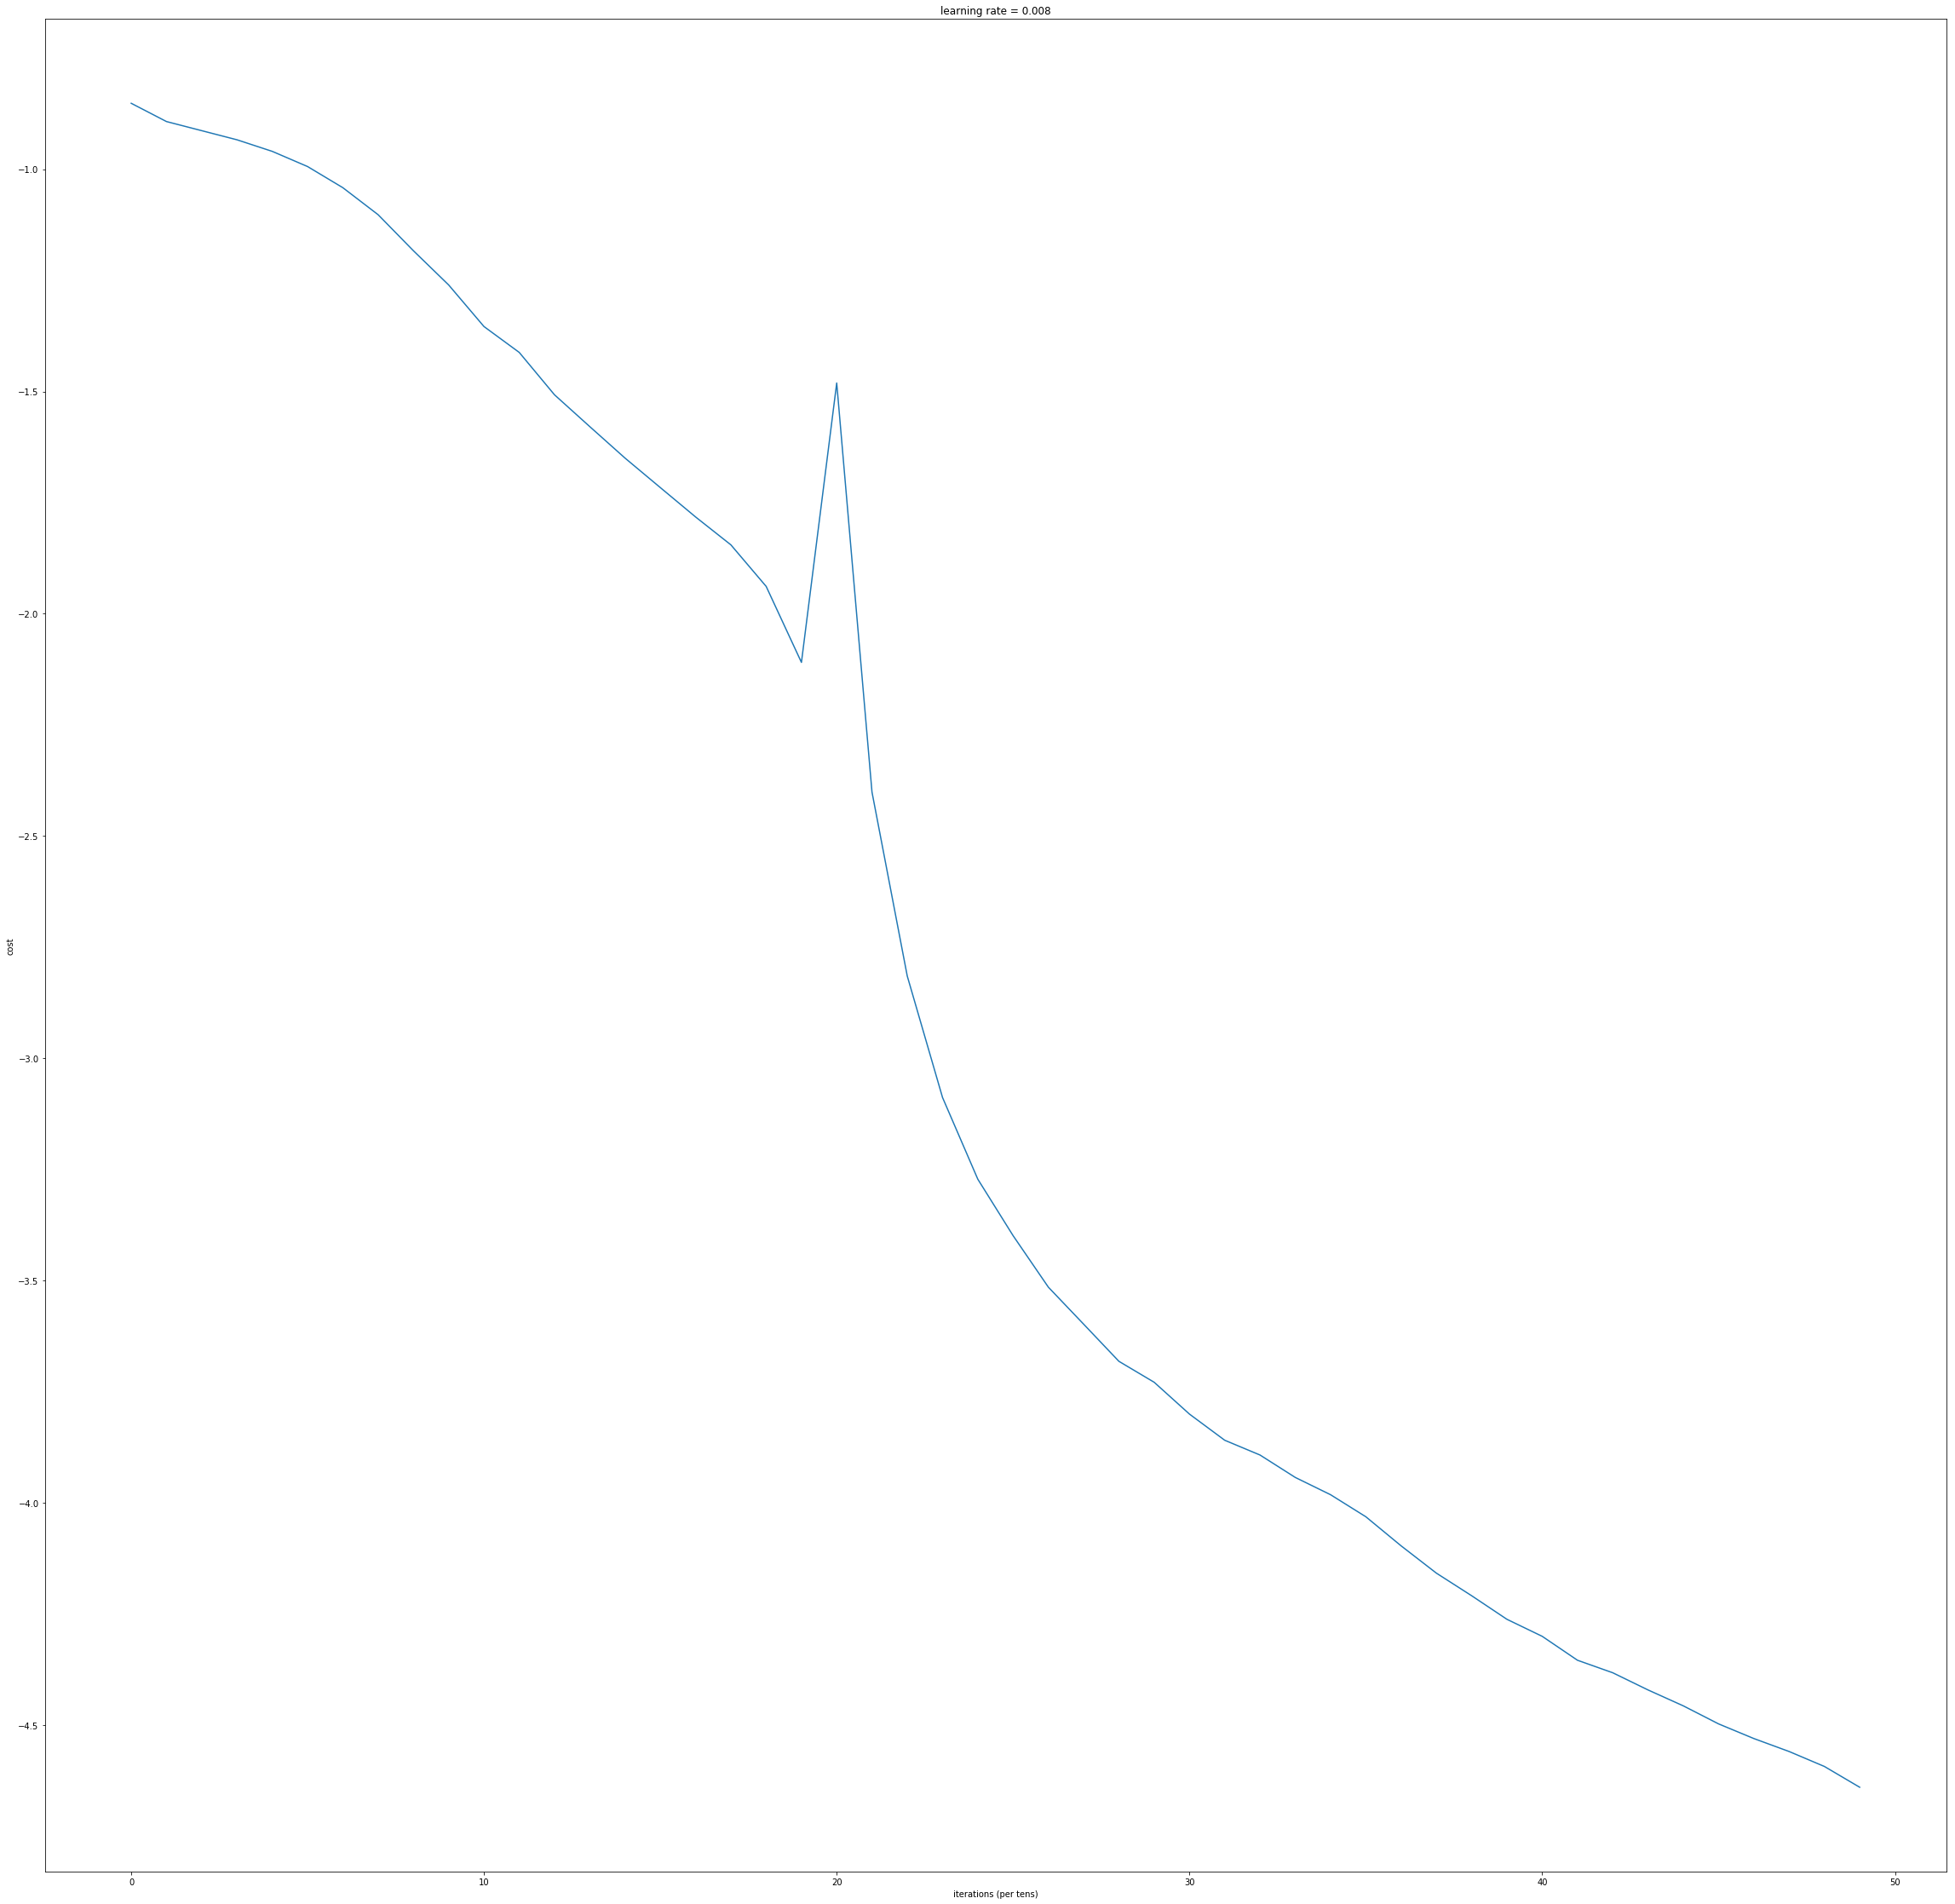

准确度为:0.9952153110047847
准确度为:0.76


In [79]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.008, num_iterations=3000, print_cost=False,isPlot=True):
    """
    实现一个L层神经网络：[LINEAR-> RELU] *（L-1） - > LINEAR-> SIGMOID。
    
    参数：
	    X - 输入的数据，维度为(n_x，例子数)
        Y - 标签，向量，0为非猫，1为猫，维度为(1,数量)
        layers_dims - 层数的向量，维度为(n_y,n_h,···,n_h,n_y)
        learning_rate - 学习率
        num_iterations - 迭代的次数
        print_cost - 是否打印成本值，每100次打印一次
        isPlot - 是否绘制出误差值的图谱
    
    返回：
     parameters - 模型学习的参数。 然后他们可以用来预测。
    """
    np.random.seed(1)
    costs = []
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0,num_iterations):
        AL, caches = L_model_forward(X,parameters)
        
        cost = compute_cost(AL,Y)
        
        grads = L_model_backward(AL,Y,caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                 print("第", i ,"次迭代，成本值为：" ,np.squeeze(cost))
    if isPlot:
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('learning rate = ' + str(learning_rate))
        plt.show()
    return parameters

train_set_x_orig , train_set_y , test_set_x_orig , test_set_y , classes = lr_utils.load_dataset()

train_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T 
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

train_x = train_x_flatten / 255
train_y = train_set_y
test_x = test_x_flatten / 255
test_y = test_set_y
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 5000, print_cost = True,isPlot=True)
#预测
pred_train = predict(train_x, train_y, parameters) #训练集
pred_test = predict(test_x, test_y, parameters) #测试集

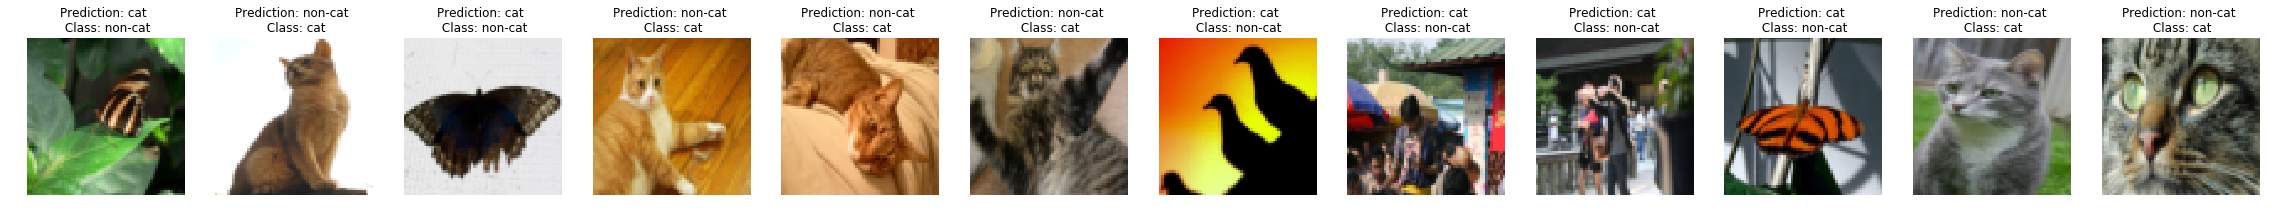

In [72]:
def print_mislabeled_images(classes, X, y, p):
    """
	绘制预测和实际不同的图像。
	    X - 数据集
	    y - 实际的标签
	    p - 预测
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


print_mislabeled_images(classes, test_x, test_y, pred_test)